This notebook uses the following files from BAM:
- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.211.113.236:~/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv ~/Downloads/experiments/dwm-test/recalibrated-percolator-output/
- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.211.113.236:~/experiments/dwm-test/coordinate-estimators/\run-\*-estimator.pkl ~/Downloads/experiments/dwm-test/coordinate-estimators/
- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@13.211.113.236:~/experiments/dwm-test/sequence-library/sequence-library.pkl ~/Downloads/experiments/dwm-test/sequence-library/

In [80]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [81]:
experiment_base_dir = '/Users/darylwilding-mcbride/Downloads/experiments'
experiment_name = 'dwm-test'

EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)
COORDINATE_ESTIMATORS_DIR = "{}/coordinate-estimators".format(EXPERIMENT_DIR)


In [82]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

In [83]:
get_percolator_run_mapping(MAPPING_FILE_NAME)

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to1_09'),
 (3, '190719_Hela_Ecoli_1to3_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_01'),
 (6, '190719_Hela_Ecoli_1to1_03'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to1_10'),
 (9, '190719_Hela_Ecoli_1to3_07'),
 (10, '190719_Hela_Ecoli_1to1_08'),
 (11, '190719_Hela_Ecoli_1to1_01'),
 (12, '190719_Hela_Ecoli_1to3_04'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_10'),
 (15, '190719_Hela_Ecoli_1to1_04'),
 (16, '190719_Hela_Ecoli_1to1_02'),
 (17, '190719_Hela_Ecoli_1to3_02'),
 (18, '190719_Hela_Ecoli_1to1_05'),
 (19, '190719_Hela_Ecoli_1to1_06')]

In [84]:
def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


In [6]:
def estimate_target_coordinates(row_as_series, mz_estimator, scan_estimator, rt_estimator):
    sequence_estimation_attribs_s = row_as_series[['theoretical_mz','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','experiment_intensity_mean','experiment_intensity_std_dev']]
    sequence_estimation_attribs = np.reshape(sequence_estimation_attribs_s.values, (1, -1))  # make it 2D

    # estimate the raw monoisotopic m/z
    mz_delta_ppm_estimated = mz_estimator.predict(sequence_estimation_attribs)[0]
    theoretical_mz = sequence_estimation_attribs_s.theoretical_mz
    estimated_monoisotopic_mz = (mz_delta_ppm_estimated / 1e6 * theoretical_mz) + theoretical_mz

    # estimate the raw monoisotopic scan
    estimated_scan_delta = scan_estimator.predict(sequence_estimation_attribs)[0]
    experiment_scan_mean = sequence_estimation_attribs_s.experiment_scan_mean
    estimated_scan_apex = (estimated_scan_delta * experiment_scan_mean) + experiment_scan_mean

    # estimate the raw monoisotopic RT
    estimated_rt_delta = rt_estimator.predict(sequence_estimation_attribs)[0]
    experiment_rt_mean = sequence_estimation_attribs_s.experiment_rt_mean
    estimated_rt_apex = (estimated_rt_delta * experiment_rt_mean) + experiment_rt_mean

    return {"mono_mz":estimated_monoisotopic_mz, "scan_apex":estimated_scan_apex, "rt_apex":estimated_rt_apex}


In [7]:
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355

# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

# the number of isotopes to look for in the m/z dimension - the theoretical model includes 7 (the monoisotopic plus 6 isotopes)
NUMBER_OF_ISOTOPES = 7

# the level of intensity at which the detector is in saturation
SATURATION_INTENSITY = 3000

In [8]:
def define_feature_region_at_coords(coordinates_d, experiment_scan_peak_width, charge, frames_subset_df):
    mono_mz = coordinates_d['mono_mz']
    scan_apex = coordinates_d['scan_apex']

    # distance for looking either side of the scan apex, based on the other times this sequence has been seen in this experiment
    SCAN_WIDTH = experiment_scan_peak_width

    # the width to use for isotopic width, in Da
    MZ_TOLERANCE_PPM = 5  # +/- this amount
    MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
    MS1_PEAK_DELTA = mono_mz * MZ_TOLERANCE_PERCENT / 100

    # the number of isotopes to look for in the m/z dimension - the theoretical model includes 7 (the monoisotopic plus 6 isotopes)
    NUMBER_OF_ISOTOPES = 7
    expected_spacing_mz = CARBON_MASS_DIFFERENCE / charge

    # define the region we will look in for the feature
    mz_lower = mono_mz - MS1_PEAK_DELTA
    mz_upper = mono_mz + (NUMBER_OF_ISOTOPES * expected_spacing_mz) + MS1_PEAK_DELTA
    scan_lower = scan_apex - (2 * SCAN_WIDTH)
    scan_upper = scan_apex + (2 * SCAN_WIDTH)

    frames_subset_df = frames_subset_df[(frames_subset_df.mz >= mz_lower) & (frames_subset_df.mz <= mz_upper) & (frames_subset_df.scan >= scan_lower) & (frames_subset_df.scan <= scan_upper)]
    return frames_subset_df


In [9]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    try:
        return ((_int_f/_int_f.sum()) * _mz_f).sum()
    except:
        print("exception in mz_centroid")
        return None

In [10]:
# define the isotopes from the estimated monoisotopic m/z and charge. Return the isotopes and the raw points in each.
def define_isotopes(mono_mz, charge, feature_region_df):
    expected_spacing_mz = CARBON_MASS_DIFFERENCE / charge
    # the width to use for isotopic width, in Da
    MZ_TOLERANCE_PPM = 5  # +/- this amount
    MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
    MS1_PEAK_DELTA = mono_mz * MZ_TOLERANCE_PERCENT / 100

    isotope_peaks_l = []
    isotope_raw_points_l = []

    for isotope_idx in range(NUMBER_OF_ISOTOPES):
        estimated_isotope_midpoint = mono_mz + (isotope_idx * expected_spacing_mz)
        isotope_mz_lower = estimated_isotope_midpoint - MS1_PEAK_DELTA
        isotope_mz_upper = estimated_isotope_midpoint + MS1_PEAK_DELTA
        isotope_raw_points_df = feature_region_df[(feature_region_df.mz >= isotope_mz_lower) & (feature_region_df.mz <= isotope_mz_upper)].copy()
        # add the isotope's raw points to the list
        isotope_raw_points_l.append(isotope_raw_points_df)
        if len(isotope_raw_points_df) > 0:
            # centroid the raw points to get the peak for the isotope
            isotope_raw_points_a = isotope_raw_points_df[['mz','intensity']].values
            mz_cent = mz_centroid(isotope_raw_points_a[:,1], isotope_raw_points_a[:,0])
            # calculate the intensity
            summed_intensity = isotope_raw_points_a[:,1].sum()  # sum all the points in the isotope
            max_intensity = isotope_raw_points_a[:,1].max()  # get the maximum intensity
        else:
            mz_cent = None
            summed_intensity = 0
            max_intensity = 0
        # add the peak to the list of isotopic peaks
        isotope_peaks_l.append((mz_cent, isotope_mz_lower, isotope_mz_upper, summed_intensity, max_intensity))
    isotope_peaks_df = pd.DataFrame(isotope_peaks_l, columns=['mz_centroid','isotope_mz_lower','isotope_mz_upper','summed_intensity','max_intensity'])
    return (isotope_peaks_df, isotope_raw_points_l)

In [11]:
# find the ms1 frame id closest to the specified retention time, and return it and one frame either side
def find_apex_frame_ids(retention_time_secs, frame_properties_file_name):
    df = pd.read_pickle(frame_properties_file_name)
    df = df[(df.MsMsType == FRAME_TYPE_MS1)][['Id','Time']]
    df = df.sort_values(by=['Id'], inplace=False)
    df['rt_delta'] = np.abs(df.Time - retention_time_secs)
    df.reset_index(drop=True, inplace=True)
    idx = df.rt_delta.idxmin()
    frames = list(df.loc[idx-1:idx+1].Id)
    return frames

In [12]:
# load the sequence library
SEQUENCE_LIBRARY_DIR = "{}/sequence-library".format(EXPERIMENT_DIR)
SEQUENCE_LIBRARY_FILE_NAME = "{}/sequence-library.pkl".format(SEQUENCE_LIBRARY_DIR)

library_sequences_df = pd.read_pickle(SEQUENCE_LIBRARY_FILE_NAME)

#### select the sequence/charge of interest, and the runs to look at

In [13]:
selected_sequence = 'ANYRDALVAFLEQHK'
selected_sequence_charge = 2

In [14]:
sequence_in_library = library_sequences_df[(library_sequences_df.sequence == selected_sequence) & (library_sequences_df.charge == selected_sequence_charge)].iloc[0]
sequence_in_library

sequence                        ANYRDALVAFLEQHK
charge                                        2
theoretical_mz                          887.965
experiment_scan_mean                    332.064
experiment_scan_std_dev                 1.53592
experiment_scan_peak_width               42.106
experiment_rt_mean                      1034.21
experiment_rt_std_dev                   1.38632
experiment_rt_peak_width                 16.236
experiment_intensity_mean                426441
experiment_intensity_std_dev            25049.4
number_of_runs_identified                     5
q_value                              0.00179653
Name: 1657, dtype: object

In [66]:
# the run of interest
run_name = '190719_Hela_Ecoli_1to1_10'
file_idx = file_idx_for_run(run_name)

In [67]:
# file names for the coordinate estimator
RUN_MZ_MODEL_FILE_NAME = '{}/run-{}-mz-estimator.pkl'.format(COORDINATE_ESTIMATORS_DIR, run_name)
RUN_SCAN_MODEL_FILE_NAME = '{}/run-{}-scan-estimator.pkl'.format(COORDINATE_ESTIMATORS_DIR, run_name)
RUN_RT_MODEL_FILE_NAME = '{}/run-{}-rt-estimator.pkl'.format(COORDINATE_ESTIMATORS_DIR, run_name)

In [68]:
# load the estimators
with open(RUN_MZ_MODEL_FILE_NAME, 'rb') as file:
    mz_estimator = pickle.load(file)
with open(RUN_SCAN_MODEL_FILE_NAME, 'rb') as file:
    scan_estimator = pickle.load(file)
with open(RUN_RT_MODEL_FILE_NAME, 'rb') as file:
    rt_estimator = pickle.load(file)

In [69]:
sequence_coords = estimate_target_coordinates(sequence_in_library, mz_estimator, scan_estimator, rt_estimator)

In [70]:
frame_properties_file_name = '/Users/darylwilding-mcbride/Downloads/{}-frame-properties-df.pkl'.format(run_name)
frame_properties_file_name

'/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli_1to1_10-frame-properties-df.pkl'

In [71]:
apex_frame_ids = find_apex_frame_ids(sequence_coords['rt_apex'], frame_properties_file_name)
apex_frame_ids

[9641, 9646, 9651]

#### run this command to extract the frames at the RT apex
- python ./open-path/notebooks/extract-rt-apex-frames.py -en dwm-test -rn 190719_Hela_Ecoli_1to1_09 -fid 9654 9659 9664

and download the output files

In [72]:
frames_subset_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/{}-frames-subset-df.pkl'.format(run_name))

In [73]:
feature_region_df = define_feature_region_at_coords(sequence_coords, sequence_in_library.experiment_scan_peak_width, sequence_in_library.charge, frames_subset_df)


In [74]:
subset_rt_apex_df = feature_region_df[feature_region_df.frame_id.isin(apex_frame_ids)]

In [75]:
(isotope_peaks_df, isotope_raw_points_l) = define_isotopes(sequence_coords['mono_mz'], selected_sequence_charge, subset_rt_apex_df)


In [76]:
monoisotopic_intensity = round(np.log2(isotope_peaks_df.iloc[0].summed_intensity), 2)
monoisotopic_intensity

11.03

In [77]:
isotope_idx_not_in_saturation = -1
for isotope_idx in range(NUMBER_OF_ISOTOPES):
    isotope_df = isotope_raw_points_l[isotope_idx]
    if isotope_df.intensity.max() <= SATURATION_INTENSITY:
        isotope_idx_not_in_saturation = isotope_idx
        break
isotope_idx_not_in_saturation

0

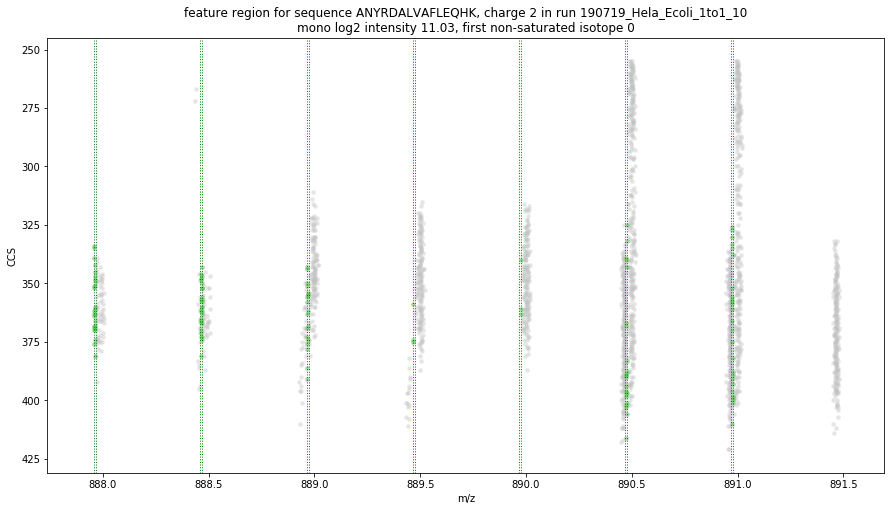

In [78]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.title('feature region for sequence {}, charge {} in run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(selected_sequence, selected_sequence_charge, run_name, monoisotopic_intensity, isotope_idx_not_in_saturation))

ax1.scatter(subset_rt_apex_df.mz, subset_rt_apex_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.4)

for isotope_idx,isotope in isotope_peaks_df.iterrows():
    isotope_mz_lower = isotope.isotope_mz_lower
    isotope_mz_upper = isotope.isotope_mz_upper
    plt.axvline(x=isotope_mz_lower, linestyle=':', linewidth=1, color='green')
    plt.axvline(x=isotope_mz_upper, linestyle=':', linewidth=1, color='green')
    ax1.scatter(isotope_raw_points_l[isotope_idx].mz, isotope_raw_points_l[isotope_idx].scan, marker='o', color='limegreen', lw=0, s=20, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('CCS')
plt.gca().invert_yaxis()

# plt.xlim((0,50))
# plt.ylim((0,20))

plt.show()

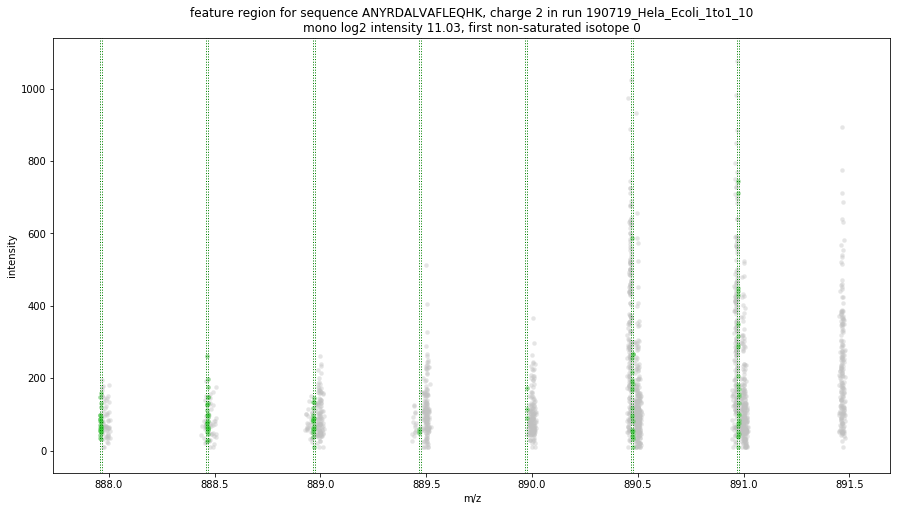

In [79]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.title('feature region for sequence {}, charge {} in run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(selected_sequence, selected_sequence_charge, run_name, monoisotopic_intensity, isotope_idx_not_in_saturation))

ax1.scatter(subset_rt_apex_df.mz, subset_rt_apex_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.4)

for isotope_idx,isotope in isotope_peaks_df.iterrows():
    isotope_mz_lower = isotope.isotope_mz_lower
    isotope_mz_upper = isotope.isotope_mz_upper
    plt.axvline(x=isotope_mz_lower, linestyle=':', linewidth=1, color='green')
    plt.axvline(x=isotope_mz_upper, linestyle=':', linewidth=1, color='green')
    ax1.scatter(isotope_raw_points_l[isotope_idx].mz, isotope_raw_points_l[isotope_idx].intensity, marker='o', color='limegreen', lw=0, s=20, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('intensity')
# plt.gca().invert_yaxis()

# plt.xlim((0,50))
# plt.ylim((0,20))

plt.show()